# Библиотеките

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import nltk
import numpy as np
import stopwordsiso as swiso

from scipy.stats import uniform
from nltk.corpus import stopwords
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler

# Зареждане на данните

In [3]:
data = pd.read_csv('multitude.csv')

In [4]:
data

,text,label,multi_label,split,language,length,source
0,Der Ausbruch des Coronavirus hat die Entwicklu...,1,text-davinci-003,test,de,174,MULTITuDE_MassiveSumm_spiegel
1,Alex Azar was officially sworn in as the U.S. ...,1,text-davinci-003,train,en,57,MULTITuDE_MassiveSumm_voanews
2,Європейський союз вимагає зупинити розтрату ко...,1,gpt-3.5-turbo,test,uk,105,MULTITuDE_MassiveSumm_interfax
3,"Yesterday, hundreds of Zambian university stud...",1,text-davinci-003,train,en,254,MULTITuDE_MassiveSumm_voanews
4,"In a narrow and highly watched vote, the US Se...",1,gpt-4,train,en,416,MULTITuDE_MassiveSumm_voanews
...,...,...,...,...,...,...,...
74076,"Боксер Олег Маскаєв відкрив вболівальникам, що...",1,gpt-3.5-turbo,test,uk,86,MULTITuDE_MassiveSumm_gazeta
74077,A sheriff in the state of Texas has reported t...,1,vicuna-13b,train,en,178,MULTITuDE_MassiveSumm_voanews
74078,-------------Уровень угрозы терроризма в Брита...,1,vicuna-13b,train,ru,60,MULTITuDE_MassiveSumm_bbc
74079,Former President Olusegun Obasanjo is facing a...,1,vicuna-13b,train,en,199,MULTITuDE_MassiveSumm_voanews


text - генериран текст

label - 0 етикет за човешки написан текст, 1 за AI генериран текст

multi_label - генериран езиков модел за изкуствени интелект / human - човешки текст

split - текста за какво ще се използва - тренировъчен сет / тестови сет

language - на какъв международен език е написан текста

length - дължината на текста

source - кой е източника на информация

# Информация за колоните и типовете данни в тях

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74081 entries, 0 to 74080
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         74081 non-null  object
 1   label        74081 non-null  int64 
 2   multi_label  74081 non-null  object
 3   split        74081 non-null  object
 4   language     74081 non-null  object
 5   length       74081 non-null  int64 
 6   source       74081 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.0+ MB


# Проверка на данните

In [15]:
duplicates = data.duplicated()
total_duplicates = duplicates.sum()
print(f"Общо дублирани редове: {total_duplicates}")

Общо дублирани редове: 0


In [16]:
missing_values = data.isnull()
total_missing = missing_values.sum()
print(f"Общо празни стойности: {total_missing}")

Общо празни стойности: text           0
label          0
multi_label    0
split          0
language       0
length         0
source         0
dtype: int64


# Aнализираме и подготвяме данните

In [18]:
data.describe()

,label,length
count,74081.000000,74081.000000
mean,0.892118,152.552962
std,0.310233,93.107789
min,0.000000,6.000000
25%,1.000000,74.000000
50%,1.000000,142.000000
75%,1.000000,215.000000
max,1.000000,512.000000


count – Броят на ненулевите стойности във всяка колона

mean – Средната стойност (аритметичното средно) на всички стойности в колоната

std – Стандартното отклонение: показва колко разпръснати са данните около средната стойност

min – Най-ниската стойност в колоната

25% – Стойността, под която попадат 25% от данните

50% (медиана) – Централната стойност: 50% от стойностите са по-малки, а 50% — по-големи

75% – Стойността, под която са 75% от данните

max – Най-високата стойност в колоната

label
1    66089
0     7992
Name: count, dtype: int64


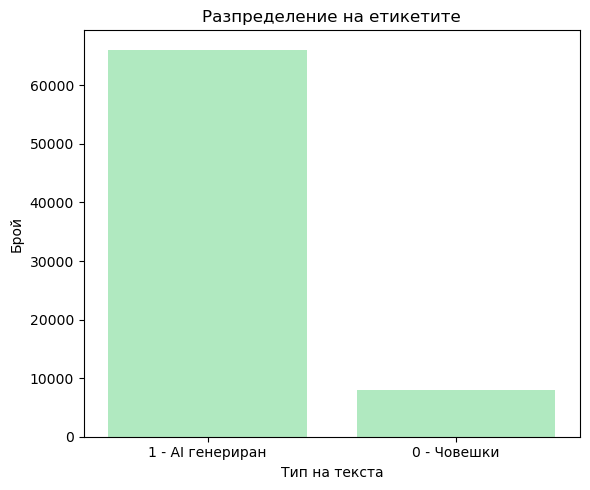

In [27]:
# Разпределение на етикети
duplicate_data = data.copy()
print(duplicate_data['label'].value_counts())

plt.figure(figsize=(6, 5))
sns.countplot(x=duplicate_data['label'].replace({0: '0 - Човешки', 1: '1 - AI генериран'}), color='#A6F3BC')
plt.title('Разпределение на етикетите')
plt.xlabel('Тип на текста')
plt.ylabel('Брой')
plt.tight_layout()
plt.show()

In [28]:
# Брой източници на информация
print(duplicate_data['source'].value_counts().to_string())

source
MULTITuDE_MassiveSumm_voanews             26434
MULTITuDE_MassiveSumm_globalvoices         4947
MULTITuDE_MassiveSumm_20minutos            4680
MassiveSumm_voanews                        3107
MULTITuDE_MassiveSumm_ria                  2985
MULTITuDE_MassiveSumm_bbc                  2843
MULTITuDE_MassiveSumm_denik                2389
MULTITuDE_MassiveSumm_rfi                  2306
MULTITuDE_MassiveSumm_rt                   2005
MULTITuDE_MassiveSumm_elpais               1406
MULTITuDE_MassiveSumm_rtve                 1402
MULTITuDE_MassiveSumm_vesti                1351
MULTITuDE_MassiveSumm_tass                 1330
MULTITuDE_MassiveSumm_welt                 1158
MULTITuDE_MassiveSumm_mk                   1097
MULTITuDE_MassiveSumm_rbc                  1087
MULTITuDE_MassiveSumm_dw                    891
MULTITuDE_MassiveSumm_publico               808
MULTITuDE_MassiveSumm_unian                 775
MULTITuDE_MassiveSumm_voaportugues          741
MassiveSumm_globalvoices         

Източниците в source представляват имената на медийните организации, от които са взети оригиналните новинарски статии в MassiveSumm. Те обхващат широк спектър от международни и регионални медии, работещи на различни езици и в различни географски контексти.

| Източник (MassiveSumm / MULTITuDE_MassiveSumm) | Описание                                                                                                     |
| ---------------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **20minutos**                                  | Испански всекидневник, базиран в Мадрид, фокусиран върху кратки и бързи новини.                                |
| **acorianooriental**                           | Португалски регионален вестник от Азорските острови, издаван от 1835 г.                                       |
| **aawsat**                                     | „Asharq Al-Awsat“ – панарабски ежедневник, базиран в Лондон, публикуван на арабски език.                      |
| **aljazeera**                                  | Международна телевизионна мрежа, базирана в Катар, известна с глобалното си отразяване на новини.             |
| **alwafd**                                     | Египетски ежедневник и новинарски портал, свързан с либералната партия „Ал Уафд“.                             |
| **amerikaninsesi**                             | Турскоезичното издание на Voice of America (VOA) – международна медия, финансирана от правителството на САЩ.  |
| **bbc**                                        | British Broadcasting Corporation – националната обществена медия на Обединеното кралство.                     |
| **denik**                                      | Чешки регионален всекидневник, обхващащ множество региони на страната.                                       |
| **dw**                                         | Deutsche Welle – германска международна обществена медия, публикуваща на много езици.                         |
| **elpais**                                     | „El País“ – водещ испански национален ежедневник, известен с политически и културни анализи.                  |
| **eremnews**                                   | Арабски онлайн новинарски портал със седалище в ОАЕ, отразяващ регионални и международни новини.             |
| **faz**                                        | Frankfurter Allgemeine Zeitung – един от най-авторитетните германски ежедневници.                             |
| **gazeta**                                     | „Gazeta.ru“ – руски онлайн новинарски портал с фокус върху политика, икономика и спорт.                       |
| **globalvoices**                               | Мрежа от граждански журналисти и блогъри по целия свят, публикуваща на много езици.                           |
| **golem**                                      | „Golem.de“ – германски технологичен новинарски портал.                                                        |
| **golosameriki**                               | Рускоезичното издание на Voice of America (VOA).                                                              |
| **interfax**                                   | Една от най-големите частни информационни агенции в Русия.                                                    |
| **kyiv**                                       | Най-вероятно Kyiv Post – англоезичен украински всекидневник (изисква потвърждение).                          |
| **meinbezirk**                                 | Австрийска регионална медийна платформа за локални новини.                                                    |
| **mk**                                         | „Московский Комсомолец“ – руски всекидневник с голяма аудитория.                                              |
| **mos**                                        | Вероятно московски локален новинарски портал (изисква потвърждение; може да е свързан с MK).                  |
| **n-tv**                                       | Германски 24-часов новинарски телевизионен канал.                                                             |
| **pravda**                                     | „Правда“ – исторически руски вестник, сега функциониращ основно онлайн.                                       |
| **publico**                                    | „Público“ – португалски национален ежедневник, базиран в Лисабон.                                             |
| **rbc**                                        | РБК (RosBusinessConsulting) – руска медийна група с фокус върху бизнес новини.                                |
| **ren**                                        | REN TV – руски национален телевизионен канал.                                                                 |
| **rfi**                                        | Radio France Internationale – френска международна радио и онлайн медия.                                      |
| **ria**                                        | РИА Новости – руска държавна новинарска агенция.                                                              |
| **rt**                                         | Russia Today – руска международна телевизия, държавно финансирана.                                            |
| **rtve**                                       | Radiotelevisión Española – испанската национална обществена медия.                                            |
| **spiegel**                                    | „Der Spiegel“ – германско седмично списание за политика, икономика и култура.                                 |
| **tass**                                       | ТАСС – официалната руска държавна информационна агенция.                                                      |
| **unian**                                      | Украинска независима информационна агенция, базирана в Киев.                                                  |
| **vesti**                                      | „Вести“ – руска телевизионна новинарска програма и онлайн портал.                                             |
| **voachinese**                                 | Китайскоезичното издание на Voice of America (VOA).                                                           |
| **voanews**                                    | Voice of America – международна медия, финансирана от правителството на САЩ, публикуваща на много езици.      |
| **voaportugues**                               | Португалскоезичното издание на Voice of America (VOA).                                                        |
| **welt**                                       | „Die Welt“ – германски национален всекидневник.                                                               |


Важна особеност на MULTITuDE е, че всеки медиен източник е представен едновременно с човешки и машинно генерирани текстове, което позволява директно сравнение между автентичното съдържание и автоматичното генериране.

Прави обаче впечатление, че машинно-генерирания текст започва с префикса MULTITuDE... (Пример: MULTITuDE_MassiveSumm_voanews), а човешки с MassiveSumm... (Пример: MassiveSumm_voanews)

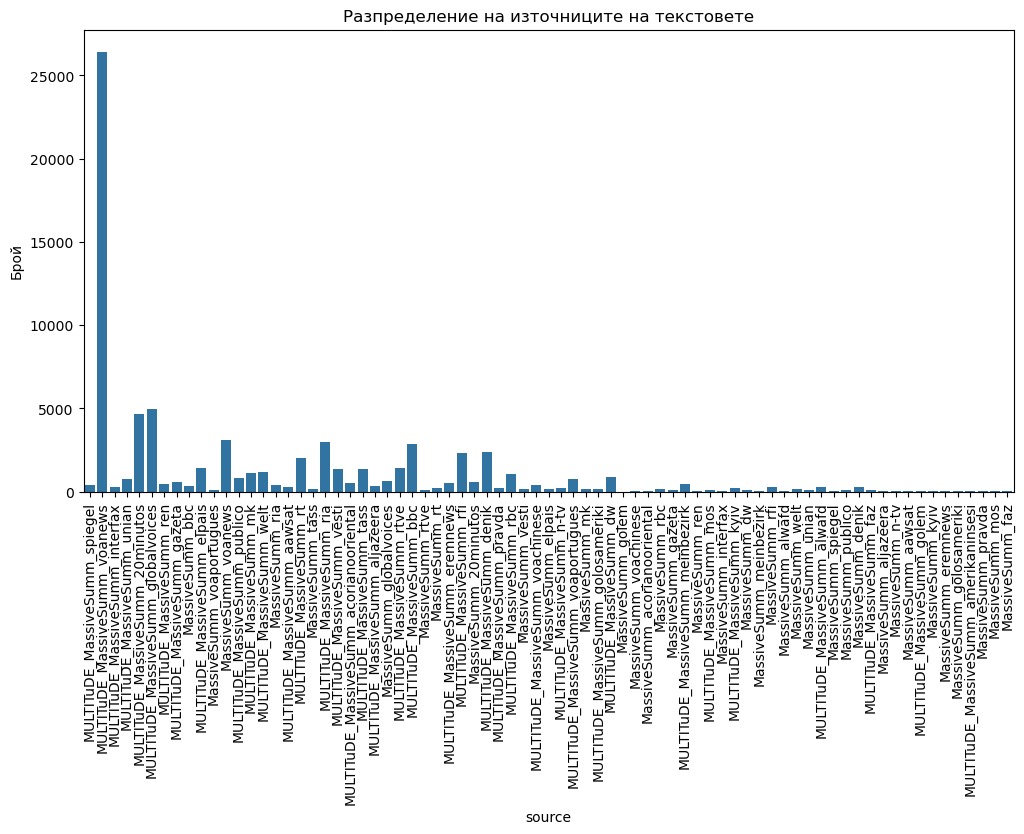

Топ 5 източника по брой текстове:
source
MULTITuDE_MassiveSumm_voanews         26434
MULTITuDE_MassiveSumm_globalvoices     4947
MULTITuDE_MassiveSumm_20minutos        4680
MassiveSumm_voanews                    3107
MULTITuDE_MassiveSumm_ria              2985
Name: count, dtype: int64


In [30]:
# Анализ на източниците на текста
plt.figure(figsize=(12, 6))
sns.countplot(x='source', data=duplicate_data)
plt.title('Разпределение на източниците на текстовете')
plt.xticks(rotation=90)
plt.ylabel('Брой')
plt.show()

top_sources = duplicate_data['source'].value_counts().head(5)
print("Топ 5 източника по брой текстове:")
print(top_sources)

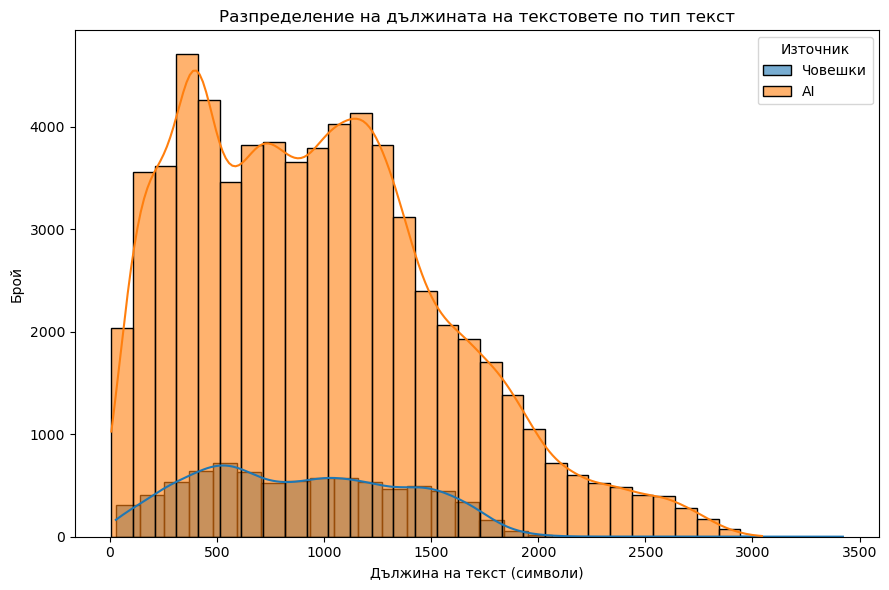

In [31]:
mask_human = duplicate_data['label'] == 0
mask_ai = duplicate_data['label'] == 1

plt.figure(figsize=(9, 6))
sns.histplot(
    duplicate_data.loc[mask_human, 'text'].str.len(),
    bins=30,
    kde=True,
    color='tab:blue',
    alpha=0.6,
    label='Човешки'
)
sns.histplot(
    duplicate_data.loc[mask_ai, 'text'].str.len(),
    bins=30,
    kde=True,
    color='tab:orange',
    alpha=0.6,
    label='AI'
)

plt.title('Разпределение на дължината на текстовете по тип текст')
plt.xlabel('Дължина на текст (символи)')
plt.ylabel('Брой')
plt.legend(title='Източник')
plt.tight_layout()
plt.show()

Брой човешки записи по езици:
language
en    3097
ru    1299
es    1221
zh     300
ca     300
cs     300
nl     299
ar     299
uk     298
de     292
pt     287
Name: count, dtype: int64

Брой AI записи по езици:
language
en    26363
es    10365
ru    10279
nl     2396
de     2393
ca     2391
cs     2389
pt     2386
zh     2383
ar     2374
uk     2370
Name: count, dtype: int64


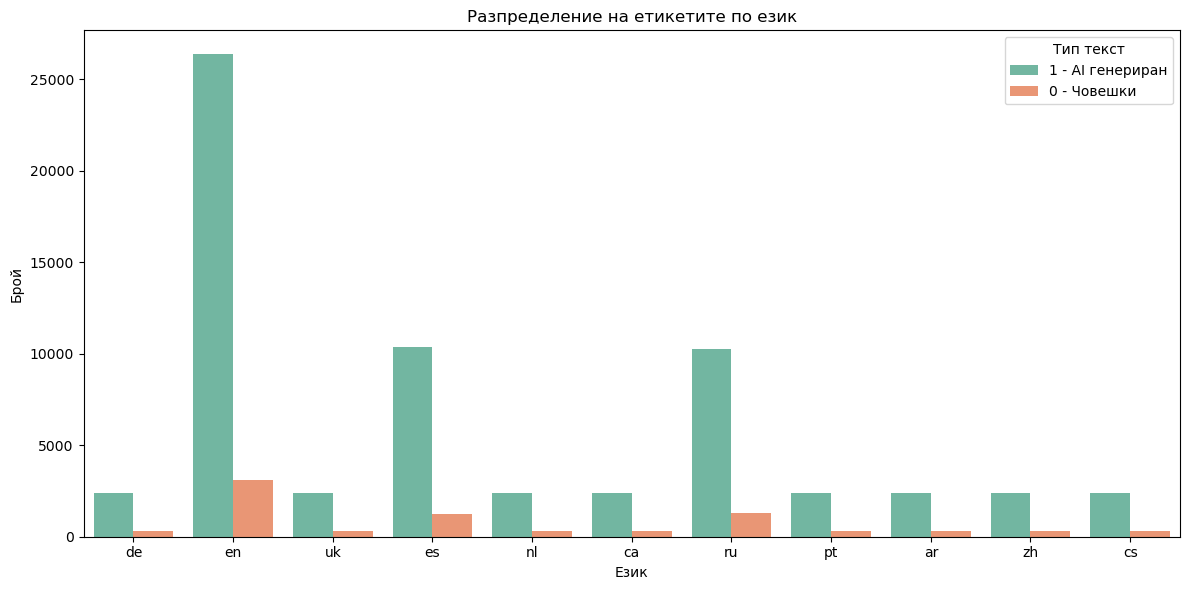

In [32]:
# Брой езици + графика
if 'language' in duplicate_data.columns:
    human_counts = duplicate_data.loc[duplicate_data['label'] == 0, 'language'] \
        .value_counts()
    ai_counts    = duplicate_data.loc[duplicate_data['label'] == 1, 'language'] \
        .value_counts()

    print("Брой човешки записи по езици:")
    print(human_counts)

    print("\nБрой AI записи по езици:")
    print(ai_counts)


plt.figure(figsize=(12, 6))
sns.countplot(
    x='language',
    hue=duplicate_data['label'].replace({0: '0 - Човешки', 1: '1 - AI генериран'}),
    data=duplicate_data,
    palette='Set2'
)

plt.title('Разпределение на етикетите по език')
plt.ylabel('Брой')
plt.xlabel('Език')
plt.legend(title='Тип текст')
plt.tight_layout()
plt.show()

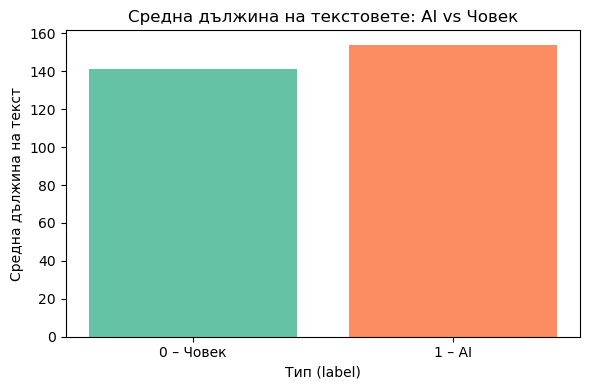

In [33]:
# Средната дължина на текстовете според този етикет 
colors = sns.color_palette('Set2', n_colors=2)

plt.figure(figsize=(6, 4))
plt.bar(['0 – Човек', '1 – AI'], 
        duplicate_data.groupby('label')['length'].mean(), 
        color=colors)

plt.title('Средна дължина на текстовете: AI vs Човек')
plt.xlabel('Тип (label)')
plt.ylabel('Средна дължина на текст')
plt.tight_layout()
plt.show()

In [34]:
# ISO → NLTK stopwords mapping
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

LANG_CODE_MAP = {
    'en': 'english',
    'es': 'spanish',
    'ru': 'russian',
    'nl': 'dutch',
    'ca': 'catalan',
    'cs': 'czech',
    'de': 'german',
    'zh': 'chinese',
    'pt': 'portuguese',
    'ar': 'arabic',
    'uk': 'ukrainian'
}

def get_nltk_lang(iso_code: str) -> str:
    """Връща езиковия код, валиден за stopwords.words()"""
    return LANG_CODE_MAP.get(iso_code, iso_code)

In [35]:
languages = duplicate_data['language'].unique()
def load_stopwords(iso_code: str) -> set:
    """
    Опитва NLTK.stopwords; ако няма списък,
    връща swiso.stopwords(iso_code).
    """
    try:
        return set(stopwords.words(iso_code if iso_code in stopwords.fileids() else LANG_CODE_MAP[iso_code]))
    except Exception:
        # за всеки език, който NLTK не поддържа, четем от stopwordsiso
        return set(swiso.stopwords(iso_code))

def get_top_words(df, lang, label, n=10):
    subset = df[(df['language'] == lang) & (df['label'] == label)]
    text = ' '.join(subset['text'].dropna()).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()

    sw = load_stopwords(lang)
    filtered = [w for w in words if w not in sw]
    return Counter(filtered).most_common(n)


def lexical_diversity(df, lang, label):
    """
    Изчислява средната лексикална разнообразност
    (уникални думи / общ брой думи) за всеки текст и връща тяхната средна стойност.
    """
    # Филтрираме и копираме, за да избегнем SettingWithCopyWarning
    subset = df[(df['language'] == lang) & (df['label'] == label)].copy()
    
    # Пресмятаме брой думи и уникални думи във всеки текст
    def compute_diversity(text):
        tokens = text.split()
        if not tokens:
            return 0.0
        return len(set(tokens)) / len(tokens)
    
    diversities = subset['text'].fillna('').apply(compute_diversity)
    return diversities.mean()


# Извеждаме топ 10 думи за всеки език и за двата етикета
for lang in languages:
    for label in (0, 1):
        top = get_top_words(duplicate_data, lang, label, n=10)
        who = 'човек' if label == 0 else 'AI'
        print(f"{lang} ({who}) – топ 10 думи:")
        for word, freq in top:
            print(f"  {word}: {freq}")
        print()  

# Пример за английски
lex_div_human = lexical_diversity(duplicate_data, lang='en', label=0)
lex_div_ai    = lexical_diversity(duplicate_data, lang='en', label=1)

print(f"Лексикално разнообразие (английски) – човек: {lex_div_human:.3f}")
print(f"Лексикално разнообразие (английски) – AI:    {lex_div_ai:.3f}")

de (човек) – топ 10 думи:
  prozent: 65
  mehr: 64
  wurde: 61
  sagte: 57
  zwei: 55
  jahr: 52
  euro: 49
  sei: 49
  veröffentlicht: 47
  lesedauer: 42

de (AI) – топ 10 думи:
  wurde: 874
  abgerufen: 851
  the: 720
  mehr: 536
  menschen: 463
  deutschland: 420
  polizei: 415
  wurden: 378
  viele: 361
  jahren: 348

en (човек) – топ 10 думи:
  said: 4577
  us: 2245
  president: 2090
  says: 1892
  people: 1609
  government: 1534
  new: 1307
  one: 1131
  also: 1124
  united: 1093

en (AI) – топ 10 думи:
  said: 23199
  us: 18841
  government: 17579
  also: 16366
  president: 13763
  new: 12798
  people: 12684
  united: 11129
  country: 9472
  international: 9392

uk (човек) – топ 10 думи:
  на: 396
  в: 386
  у: 362
  і: 241
  не: 158
  за: 127
  україни: 99
  які: 56
  а: 53
  його: 51

uk (AI) – топ 10 думи:
  на: 3300
  у: 3228
  в: 3152
  і: 1927
  не: 1311
  за: 1293
  україни: 1091
  які: 633
  його: 562
  а: 517

es (човек) – топ 10 думи:
  años: 359
  según: 336
  dos: 27

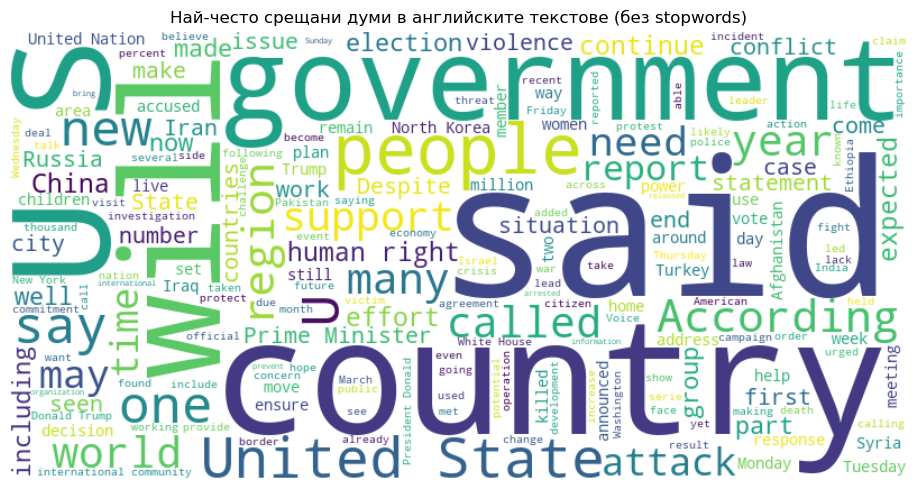

In [36]:
# Най-често използваните думи в английските текстове
en_texts = duplicate_data[duplicate_data['language'] == 'en']['text'].dropna().astype(str)

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(en_texts)
words = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

word_freq = pd.DataFrame({'word': words, 'count': counts})
top_words = word_freq.sort_values(by='count', ascending=False).head(20)
custom_stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(" ".join(en_texts))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Най-често срещани думи в английските текстове (без stopwords)')
plt.tight_layout()
plt.show()

split
train    44786
test     29295
Name: count, dtype: int64


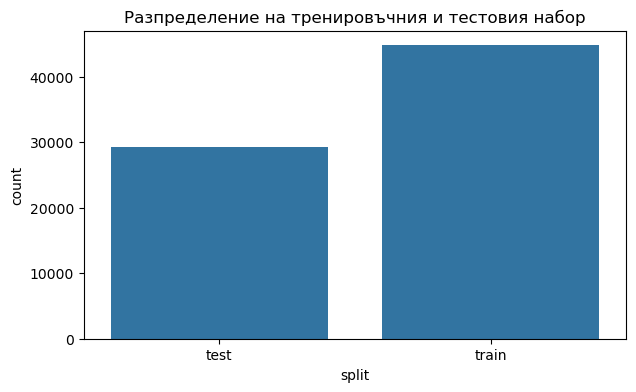

In [37]:
# Разпределение на тренировъчния и тестовия набор
# Колко примери са в тренировъчния и тестовия набор.
print(duplicate_data['split'].value_counts())

plt.figure(figsize=(7, 4))
sns.countplot(x='split', data=duplicate_data)
plt.title('Разпределение на тренировъчния и тестовия набор')
plt.show()

In [38]:
# Разделяне на данните въз основа на колоната 'split'
train_data = duplicate_data[duplicate_data['split'] == 'train']
test_data = duplicate_data[duplicate_data['split'] == 'test']

print(f"Езици в тренировъчния набор: {train_data['language'].value_counts()}")
print(f"Езици в тестовия набор: {test_data['language'].value_counts()}")

Езици в тренировъчния набор: language
en    26969
es     8910
ru     8907
Name: count, dtype: int64
Езици в тестовия набор: language
nl    2695
ca    2691
cs    2689
de    2685
zh    2683
es    2676
pt    2673
ar    2673
ru    2671
uk    2668
en    2491
Name: count, dtype: int64


In [39]:
# Понеже в тренировъчния има 3 езика, изравняваме и в тестовия да има същите три
# Извличаме списъка с езиците от train_data (уникални стойности)
train_languages = train_data['language'].unique()
filtered_test_data = test_data[test_data['language'].isin(train_languages)]
print("Езици след филтриране на тестовия набор:")
print(filtered_test_data['language'].value_counts())

Езици след филтриране на тестовия набор:
language
es    2676
ru    2671
en    2491
Name: count, dtype: int64


In [40]:
filtered_test_data

,text,label,multi_label,split,language,length,source
7,International surgeons from around the world h...,1,alpaca-lora-30b,test,en,156,MULTITuDE_MassiveSumm_voanews
18,The construction of the Grand Ethiopian Renais...,1,gpt-3.5-turbo,test,en,272,MULTITuDE_MassiveSumm_voanews
28,Суд по делу об убийстве Бориса Немцова удовлет...,0,human,test,ru,79,MassiveSumm_bbc
46,The launch of the space shuttle Discovery has ...,1,gpt-3.5-turbo,test,en,171,MULTITuDE_MassiveSumm_voanews
54,El general Carlos Rojas durante el juicio cont...,1,opt-66b,test,es,212,MULTITuDE_MassiveSumm_rt
...,...,...,...,...,...,...,...
74025,Literatura inglesa: regular. Francés: prosa mu...,0,human,test,es,19,MassiveSumm_bbc
74043,A suicide bomber attacked a group of Chinese e...,1,gpt-3.5-turbo,test,en,156,MULTITuDE_MassiveSumm_voanews
74051,"Согласно информации, полученной от источников ...",1,vicuna-13b,test,ru,125,MULTITuDE_MassiveSumm_ria
74053,en un nuevo mar de la noche. Se desprende de s...,1,opt-iml-max-1.3b,test,es,182,MULTITuDE_MassiveSumm_20minutos


In [41]:
# Премахваме старите тестови данни с всички езици от duplicate_data
duplicate_data = duplicate_data[duplicate_data['split'] != 'test']

# Добавяме обратно само филтрираните редове
duplicate_data = pd.concat([duplicate_data, filtered_test_data], ignore_index=True)

print("Нови езици в duplicate_data за split='test':")
print(duplicate_data[duplicate_data['split'] == 'test']['language'].value_counts())

Нови езици в duplicate_data за split='test':
language
es    2676
ru    2671
en    2491
Name: count, dtype: int64


In [42]:
duplicate_data

,text,label,multi_label,split,language,length,source
0,Alex Azar was officially sworn in as the U.S. ...,1,text-davinci-003,train,en,57,MULTITuDE_MassiveSumm_voanews
1,"Yesterday, hundreds of Zambian university stud...",1,text-davinci-003,train,en,254,MULTITuDE_MassiveSumm_voanews
2,"In a narrow and highly watched vote, the US Se...",1,gpt-4,train,en,416,MULTITuDE_MassiveSumm_voanews
3,"In the aftermath of the Paris attacks, the Rep...",1,opt-66b,train,en,324,MULTITuDE_MassiveSumm_voanews
4,"Voice of America (VOA), the official broadcast...",1,text-davinci-003,train,en,22,MULTITuDE_MassiveSumm_voanews
...,...,...,...,...,...,...,...
52619,Literatura inglesa: regular. Francés: prosa mu...,0,human,test,es,19,MassiveSumm_bbc
52620,A suicide bomber attacked a group of Chinese e...,1,gpt-3.5-turbo,test,en,156,MULTITuDE_MassiveSumm_voanews
52621,"Согласно информации, полученной от источников ...",1,vicuna-13b,test,ru,125,MULTITuDE_MassiveSumm_ria
52622,en un nuevo mar de la noche. Se desprende de s...,1,opt-iml-max-1.3b,test,es,182,MULTITuDE_MassiveSumm_20minutos


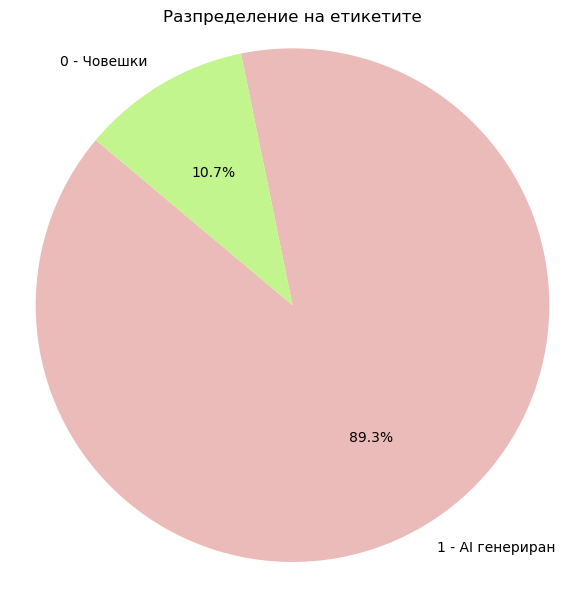

Човешки текстове (label = 0): 5617 (10.67%)
AI генерирани текстове (label = 1): 47007 (89.33%)


In [43]:
# Разпределение на етикети във duplicate_data
label_counts = duplicate_data['label'].value_counts()

labels = label_counts.index.map({0: '0 - Човешки', 1: '1 - AI генериран'})
sizes = label_counts.values
colors = ['#ebbbb9', '#c3f58e'] 

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Разпределение на етикетите')
plt.axis('equal') 
plt.tight_layout()
plt.show()

total = label_counts.sum()
percent_0 = (label_counts.get(0, 0) / total) * 100
percent_1 = (label_counts.get(1, 0) / total) * 100
print(f"Човешки текстове (label = 0): {label_counts.get(0, 0)} ({percent_0:.2f}%)")
print(f"AI генерирани текстове (label = 1): {label_counts.get(1, 0)} ({percent_1:.2f}%)")

Понеже записите на AI генерирания текст са много повече от човешките, може да повлияе на крайните резултати при използването на моделите. Затова най-подходящия начин да продължим е с under-sampling.

In [45]:
# Премахваме данни от 1-AI, за да стане балансиран дататсета
train_data = duplicate_data[duplicate_data['split'] == 'train']
test_data  = duplicate_data[duplicate_data['split'] == 'test']

X_train = train_data['text']
y_train = train_data['label']

# Прилагаме undersampling, за да балансираме label=0 и label=1
rus = RandomUnderSampler(random_state=42)
indices = X_train.index.values.reshape(-1, 1)       # преобразуваме индекси в 2D масив
idx_res, y_train_bal = rus.fit_resample(indices, y_train)

# Създаваме нов DataFrame с оригиналните текстове (по индекси на undersampled)
balanced_indices = idx_res.flatten()
df_balanced = train_data.loc[balanced_indices].reset_index(drop=True)

# df_balanced съдържа оригиналните текстове и етикети, вече балансирани

In [46]:
# Проверка на дублиращи се текстове
common_texts = set(df_balanced['text']).intersection(set(test_data['text']))
print(f"Намерени дублиращи се текстове между train и test: {len(common_texts)}")

if common_texts:
    print("\nПримери за дублиращи се текстове:")
    for txt in list(common_texts)[:10]:
        print("-", txt)

if common_texts:
    train_dupes = df_balanced[df_balanced['text'].isin(common_texts)]
    test_dupes = test_data[test_data['text'].isin(common_texts)]

    print("\nTrain записи с дублирани текстове:")
    print(train_dupes[['text','label']].reset_index(drop=True))

    print("\nTest записи с дублирани текстове:")
    print(test_dupes[['text','label']].reset_index(drop=True))

Намерени дублиращи се текстове между train и test: 0


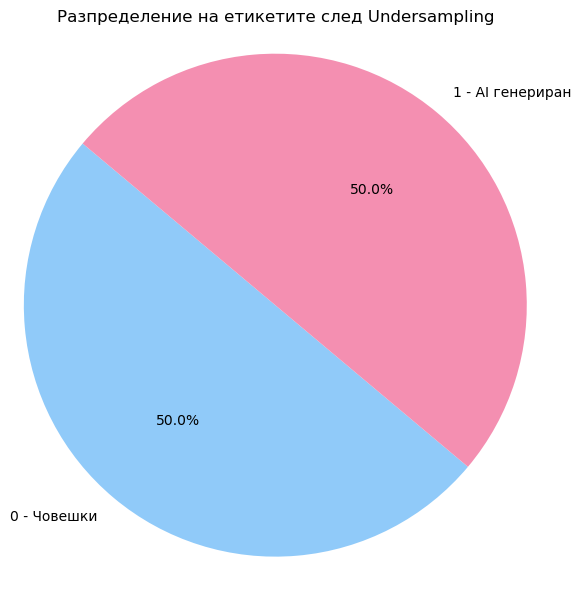

Човешки текстове (label = 0): 4756
AI генерирани текстове (label = 1): 4756


In [47]:
# Визуализираме след under-sampling
label_counts = df_balanced['label'].value_counts()
labels = label_counts.index.map({0: '0 - Човешки', 1: '1 - AI генериран'})
sizes = label_counts.values
colors = ['#90caf9', '#f48fb1']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Разпределение на етикетите след Undersampling')
plt.axis('equal')
plt.tight_layout()
plt.show()

count_0 = label_counts.get(0, 0)
count_1 = label_counts.get(1, 0)

print(f"Човешки текстове (label = 0): {count_0}")
print(f"AI генерирани текстове (label = 1): {count_1}")

Само 4756 текста са от човек в train_data, тъй като останалите 861 са в split='test'

In [49]:
df_balanced

,text,label,multi_label,split,language,length,source
0,Israeli security guards have foiled an alleged...,0,human,train,en,129,MassiveSumm_voanews
1,WASHINGTON - No matter what happens with the n...,0,human,train,en,241,MassiveSumm_voanews
2,Совещание с главами регионов Северного Кавказа...,0,human,train,ru,79,MassiveSumm_bbc
3,"НАЛЬЧИК, 28 авг — РИА Новости. Министерство ст...",0,human,train,ru,58,MassiveSumm_ria
4,"Fri, 02/05/2021 - 05:05 PMCOVID-19 Variants: U...",0,human,train,en,11,MassiveSumm_voanews
...,...,...,...,...,...,...,...
9507,Сегодня стало известно о трагическом инциденте...,1,gpt-4,train,ru,103,MULTITuDE_MassiveSumm_golosameriki
9508,"On July 12th, Dr. Fakhruddin Attar was arreste...",1,alpaca-lora-30b,train,en,93,MULTITuDE_MassiveSumm_voanews
9509,"В среду, двенадцатое февраля, власти Хельсинки...",1,text-davinci-003,train,ru,43,MULTITuDE_MassiveSumm_ria
9510,The United States Department of State has cond...,1,text-davinci-003,train,en,167,MULTITuDE_MassiveSumm_voanews


# Разделяне на данните на train и test

In [51]:
X = df_balanced['text']
y = df_balanced['label']

# Разделяне: 70% train / 30% test
X_train, X_test = train_test_split(X, test_size=0.3, random_state=45, stratify=y)

df_balanced['split'] = 'test'  
df_balanced.loc[X_train.index, 'split'] = 'train'  

print(df_balanced['split'].value_counts())

split
train    6658
test     2854
Name: count, dtype: int64


# Logistic Regression

In [53]:
train_df = df_balanced[df_balanced['split'] == 'train']
test_df = df_balanced[df_balanced['split'] == 'test']

# Фитваме TF-IDF само върху train
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(train_df['text'])
y_train = train_df['label']

# Трансформираме теста със същия векторизатор
X_test_vec = vectorizer.transform(test_df['text'])
y_test = test_df['label']

lr = LogisticRegression(
    solver='liblinear',
    random_state=10,
    class_weight='balanced',
    C=1.1408436186354975,
    penalty='l2'
)
lr.fit(X_train_vec, y_train)

y_pred = lr.predict(X_test_vec)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
tn_lr, fp_lr, fn_lr, tp_lr = cm.ravel()
accuracy_lr = accuracy_score(test_df['label'], y_pred)

print(f"\n Точност: {accuracy_lr * 100:.2f}%")
print(f" True Positive rate :  {tp_lr} from {tp_lr + fn_lr}")
print(f" True Negative rate :  {tn_lr} from {tn_lr + fp_lr}")
print(f" False Positive rate :  {fp_lr} from {fp_lr + tn_lr}")
print(f" False Negative rate :  {fn_lr} from {fn_lr + tp_lr}")


Classification Report:
              precision    recall  f1-score   support

           0      0.757     0.827     0.791      1427
           1      0.809     0.735     0.770      1427

    accuracy                          0.781      2854
   macro avg      0.783     0.781     0.781      2854
weighted avg      0.783     0.781     0.781      2854


 Точност: 78.10%
 True Positive rate :  1049 from 1427
 True Negative rate :  1180 from 1427
 False Positive rate :  247 from 1427
 False Negative rate :  378 from 1427


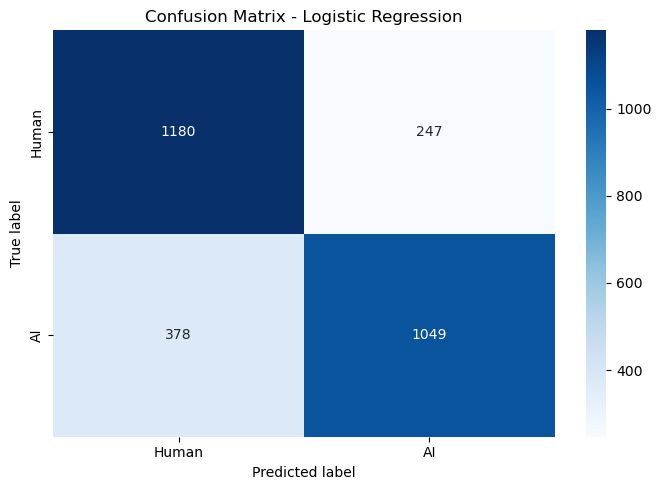

In [54]:
# Визуализация на confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(test_df['label'], y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

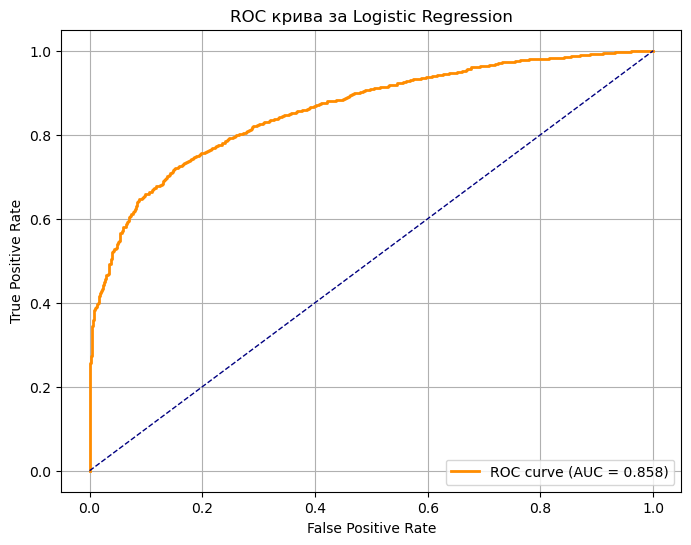

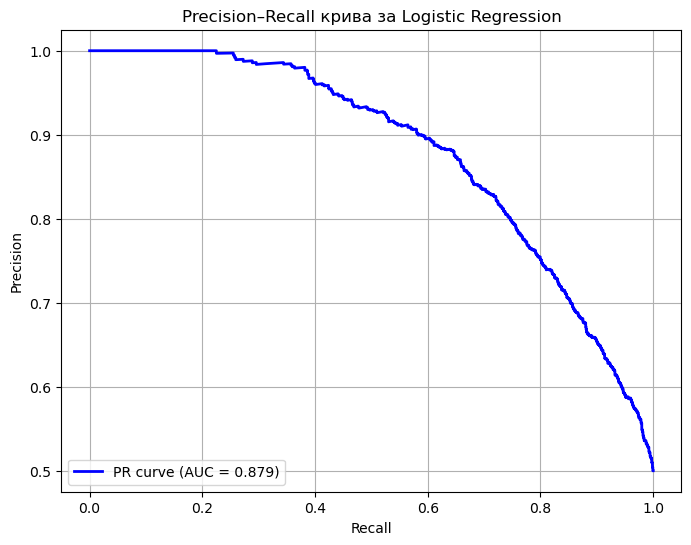

In [55]:
# ROC кривата и AUC
y_scores = lr.predict_proba(X_test_vec)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC крива за Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision–Recall крива и AUC
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall крива за Logistic Regression')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## Изводи за логистичната регресия:
Моделът постига точност от 78.10%, което е стабилен резултат предвид сходния стил на текстовете, генерирани от хора и AI. Той улавя добре и двата класа, макар все още да има място за оптимизация при по-фини езикови различия.

### True Positive Rate (чувствителност):
Моделът правилно разпознава 1 049 от общо 1 427 AI текста (73.5%), което показва добър капацитет за идентифициране на изкуствено генерирано съдържание.

### True Negative Rate (специфичност):
1 180 от 1 427 човешки текста са класифицирани коректно (82.7%), демонстрирайки способността на модела да различава автентични човешки съобщения.

### False Positive Rate:
247 човешки текста са били неправилно маркирани като AI, което говори за умерена „прекомерна подозрителност“ от страна на модела.

### False Negative Rate
378 AI текста са приети за човешки, което означава, че има възможност за подобрение при улавянето на по-естествено звучащи изкуствени формулировки.

Precision за човешкия клас е 75.7%, а за AI – 80.9%. Макро-F1 от 0.781 показва балансирано представяне без сериозен пристраст към нито един от двата класа.

### ROC-AUC и Precision–Recall AUC
При моделa с логистична регресия ROC-AUC от 0.858 показва, че в 85.8% от случаите моделът ще даде по-висока оценка на случаен позитивен пример спрямо случаен негативен. PR-AUC от 0.879 означава, че средно при всички прагове компромисът между прецизност и пълнота за позитивния клас е 87.9%. Тези стойности потвърждават добро разделяне на двата класа и ефективно улавяне на истинските позитиви дори при дисбалансирани данни.

# Naive Bayes

In [58]:
X_train, y_train = train_df['text'], train_df['label']
X_test, y_test = test_df ['text'], test_df ['label']

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    sublinear_tf=True,
    max_df=0.9,
    min_df=2
)

X_train_vec = vectorizer.fit_transform(X_train)   
X_test_vec = vectorizer.transform(X_test)        

params = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0, 3.0]}
gs = GridSearchCV(MultinomialNB(), params, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train_vec, y_train)

best_alpha = gs.best_params_['alpha']

nb = MultinomialNB(alpha=best_alpha)
nb.fit(X_train_vec, y_train)

y_pred = nb.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)
tn_nb, fp_nb, fn_nb, tp_nb = cm.ravel()
accuracy_nb = accuracy_score(y_test, y_pred)

print(f"\n Точност: {accuracy_nb * 100:.2f}%")
print(f" True Positive rate: {tp_nb} from {tp_nb + fn_nb}")
print(f" True Negative rate: {tn_nb} from {tn_nb + fp_nb}")
print(f" False Positive rate: {fp_nb} from {fp_nb + tn_nb}")
print(f" False Negative rate: {fn_nb} from {fn_nb + tp_nb}")

print("\n Confusion Matrix:")
print(cm)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, digits=3))


 Точност: 76.49%
 True Positive rate: 1004 from 1427
 True Negative rate: 1179 from 1427
 False Positive rate: 248 from 1427
 False Negative rate: 423 from 1427

 Confusion Matrix:
[[1179  248]
 [ 423 1004]]

 Classification Report:
              precision    recall  f1-score   support

           0      0.736     0.826     0.778      1427
           1      0.802     0.704     0.750      1427

    accuracy                          0.765      2854
   macro avg      0.769     0.765     0.764      2854
weighted avg      0.769     0.765     0.764      2854



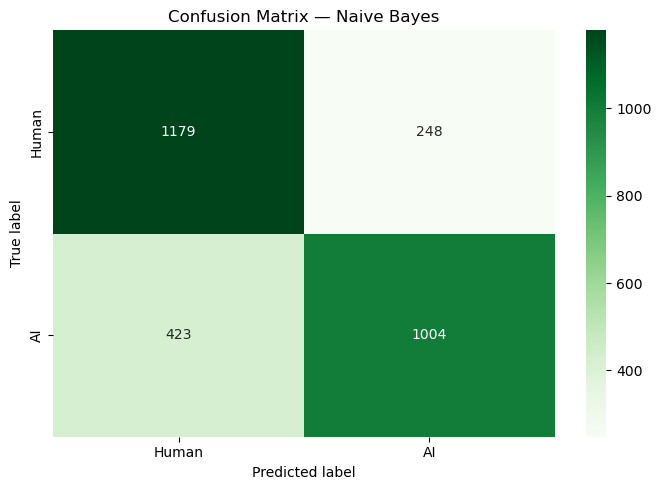

In [59]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Naive Bayes")
plt.tight_layout()
plt.show()

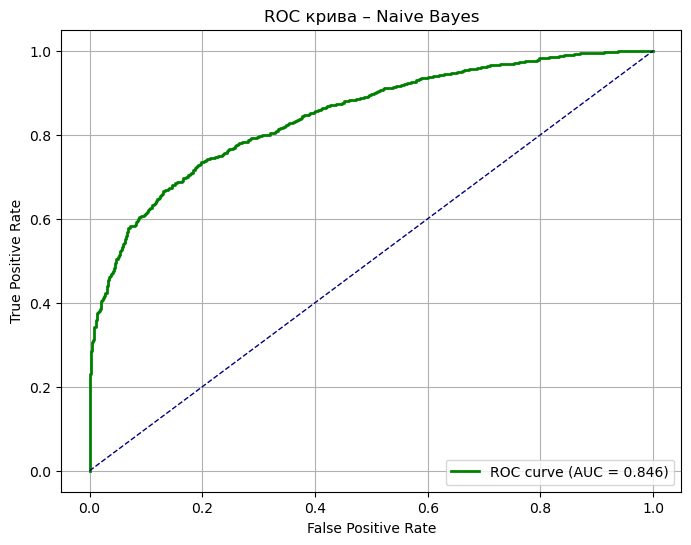

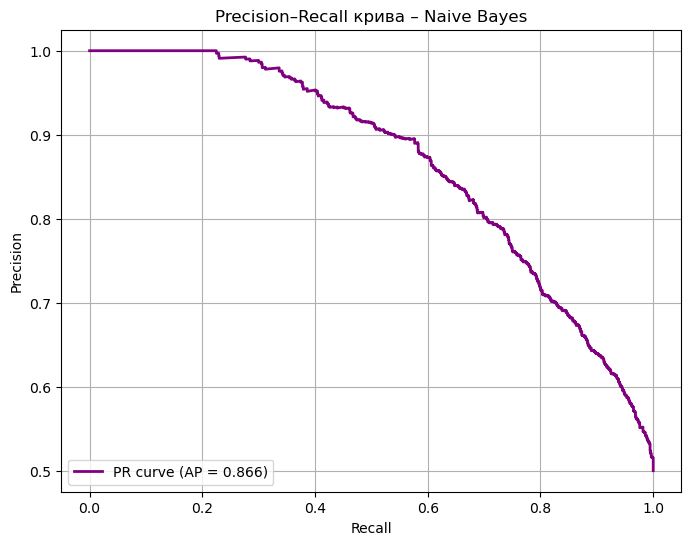

ROC AUC: 0.846
Precision–Recall AUC (AP): 0.866


In [60]:
# ROC-AUC
y_scores = nb.predict_proba(X_test_vec)[:, 1]  # вероятности за клас 1
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC крива – Naive Bayes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision–Recall AUC 
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall крива – Naive Bayes')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print(f"ROC AUC: {roc_auc:.3f}")
print(f"Precision–Recall AUC (AP): {pr_auc:.3f}")

## Изводи за Naive Bayes:
Моделът достига точност от 76.49%, което означава, че класифицира правилно приблизително 3 от всеки 4 текста. Това е значително подобрение спрямо предходната версия и го утвърждава като ефективен избор при задачи с ограничени ресурси и нужда от бърза интерпретация.

### True Positive Rate (чувствителност):
Моделът идентифицира 1 004 от 1 427 AI текста (70.4%), което показва задоволителна способност за разпознаване на генерирано съдържание. Това ниво на чувствителност е полезно за сценарии, в които е важно да се уловят максимално много AI примери.

### True Negative Rate (специфичност):
1 179 от 1 427 човешки текста (82.6%) са класифицирани коректно, което свидетелства за добра точност при разпознаване на реални текстове. Това е значително подобрение спрямо предишния модел, който бъркаше повече човешки текстове.

### False Negatives (пропуснати AI текстове):
423 текста са погрешно отчетени като човешки. Това показва, че някои AI текстове са достатъчно убедителни, за да подведат модела — важно да се отчита при приложения, където улавянето на автоматично генерирано съдържание е критично.

### False Positives (грешно класифицирани човешки текстове):
248 човешки текста са класифицирани като AI. Макар че това е понижение спрямо по-ранните резултати, то все пак може да бъде проблематично при сценарии, в които прецизното разграничаване на човешки текстове е от особено значение.

### ROC-AUC и Precision–R
Моделът Naive Bayes показва отлична класификационна способност с ROC AUC = 0.846 и AP = 0.866, което го прави надежден избор при разпознаване на AI съдържание. Той поддържа висока прецизност дори при небалансирани класове, без значителен компромис със специфичността.

Моделът демонстрира по-добро улавяне на AI съдържание (по-висока чувствителност), но по-слаба способност за разграничаване на човешки текстове. Подходящ е, когато е по-важно да не се изпуснат AI примери, но при сценарии, където фалшивите аларми са критични, ще е нужна допълнителна оптимизация.

# Random Forest

In [68]:
X_train, y_train = train_df['text'], train_df['label']
X_test, y_test = test_df ['text'],  test_df ['label']

tfidf = TfidfVectorizer(stop_words='english')
X_train_vec  = tfidf.fit_transform(X_train)   
X_test_vec = tfidf.transform(X_test)        

rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced', n_jobs=-1)

param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced"]
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=15,            
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_vec, y_train)

y_pred = search.best_estimator_.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)
tn_rf, fp_rf, fn_rf, tp_rf = cm.ravel()
accuracy_rf = accuracy_score(y_test, y_pred)

print(f"\n Точност: {accuracy_rf * 100:.2f}%")
print(f" True Positive rate :  {tp_rf} from {tp_rf + fn_rf}")
print(f" True Negative rate :  {tn_rf} from {tn_rf + fp_rf}")
print(f" False Positive rate :  {fp_rf} from {fp_rf + tn_rf}")
print(f" False Negative rate :  {fn_rf} from {fn_rf + tp_rf}")

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

Fitting 3 folds for each of 15 candidates, totalling 45 fits

 Точност: 80.80%
 True Positive rate :  1100 from 1427
 True Negative rate :  1206 from 1427
 False Positive rate :  221 from 1427
 False Negative rate :  327 from 1427

Confusion Matrix:
[[1206  221]
 [ 327 1100]]

Classification Report:
              precision    recall  f1-score   support

           0      0.787     0.845     0.815      1427
           1      0.833     0.771     0.801      1427

    accuracy                          0.808      2854
   macro avg      0.810     0.808     0.808      2854
weighted avg      0.810     0.808     0.808      2854



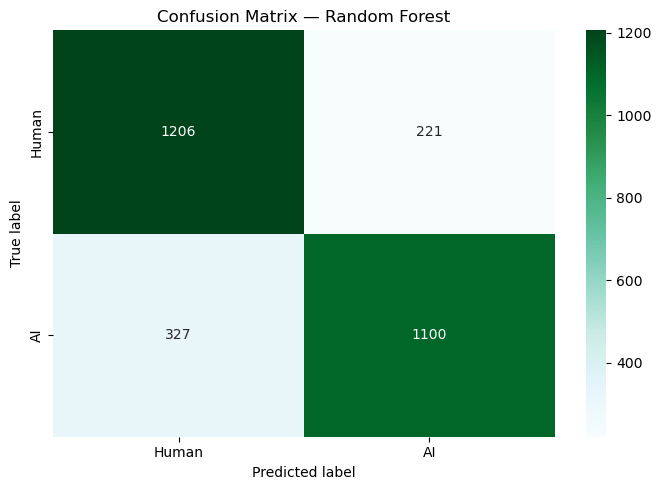

In [70]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()

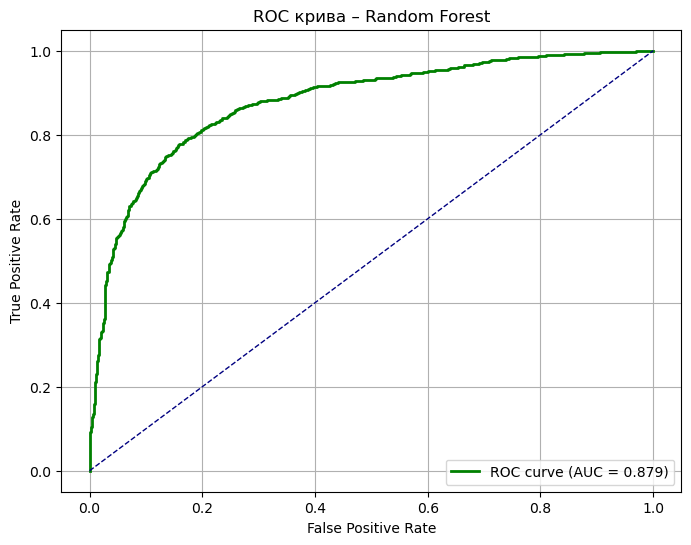

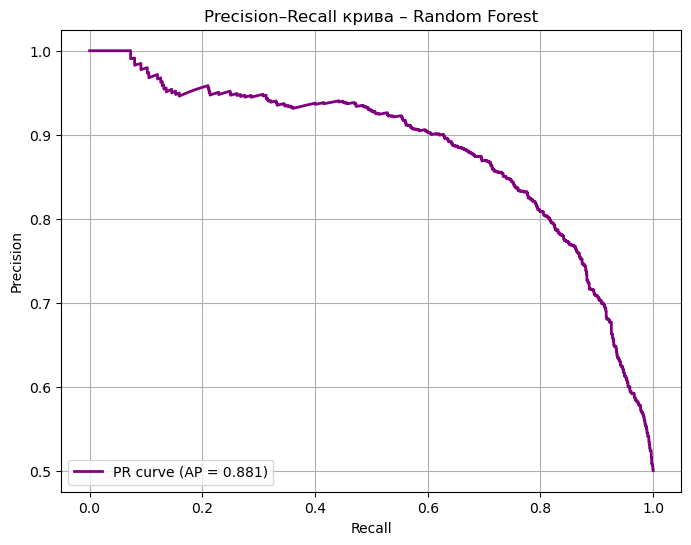

ROC AUC: 0.879
Precision–Recall AUC (AP): 0.881


In [74]:
y_scores = search.best_estimator_.predict_proba(X_test_vec)[:, 1]

# ===== ROC крива =====
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC крива – Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision–Recall крива 
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall крива – Random Forest')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print(f"ROC AUC: {roc_auc:.3f}")
print(f"Precision–Recall AUC (AP): {pr_auc:.3f}")

## Изводи за Random Forest:
80.80% – моделът класифицира правилно малко над 8 от всеки 10 текста, което е силен резултат и показва добра обща производителност.

### True Positive Rate (чувствителност):
Моделът успешно е разпознал 1 100 от 1 427 AI текста (77.1%), което говори за стабилна способност да идентифицира изкуствено съдържание.

### True Negative Rate (специфичност):
1 206 от 1 427 човешки текста (84.5%) са класифицирани коректно. Това показва висока точност при разграничаване на автентични човешки текстове от AI.

### False Negatives (пропуснати AI текстове):
327 AI текста са сгрешени като човешки. Това подсказва, че определена част от генерираното съдържание звучи достатъчно естествено, за да подведе дори сложен модел като Random Forest — важен фактор при чувствителни приложения.

### False Positives (грешно класифицирани човешки текстове):
221 човешки текста са определени неправилно като AI, което е сравнително ниска стойност спрямо някои други модели. Това означава по-малко фалшиви тревоги.

### ROC-AUC и Precision–R
Много силни резултати с ROC AUC = 0.879 и AP = 0.881, което говори за отлична способност да различава класовете. Моделът поддържа висока прецизност и при по-голям обхват на откриване, което го прави надежден избор дори при дисбаланс в данните.

Random Forest постига най-високата точност в теста, като съчетава силна чувствителност и специфичност. Той редуцира както FP, така и FN спрямо базови модели и е подходящ, когато се търси надежден модел, който едновременно улавя повечето AI текстове и рядко маркира човешките като изкуствени.

# Изводи

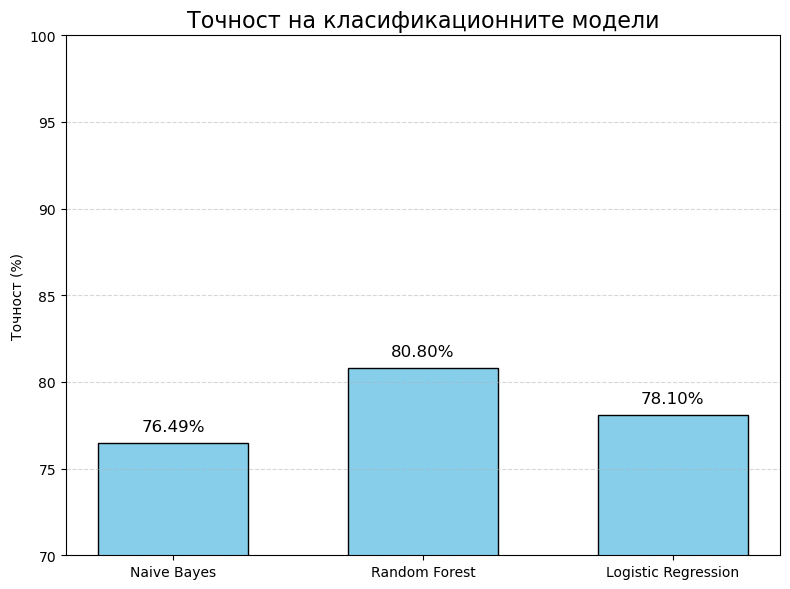

In [76]:
models = ["Naive Bayes", "Random Forest", "Logistic Regression"]
accuracies = [accuracy_nb, accuracy_rf, accuracy_lr]

accuracies_percent = [acc * 100 for acc in accuracies]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies_percent, color='skyblue', edgecolor='black', width=0.6)

plt.title('Точност на класификационните модели', fontsize=16)
plt.ylabel('Точност (%)')
plt.ylim(70, 100)  

for bar, acc in zip(bars, accuracies_percent):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{acc:.2f}%', 
             ha='center', va='bottom', fontsize=12, color='black')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [78]:
tpr_rates = [tp_nb / (tp_nb + fn_nb),
             tp_rf / (tp_rf + fn_rf),
             tp_lr / (tp_lr + fn_lr)]

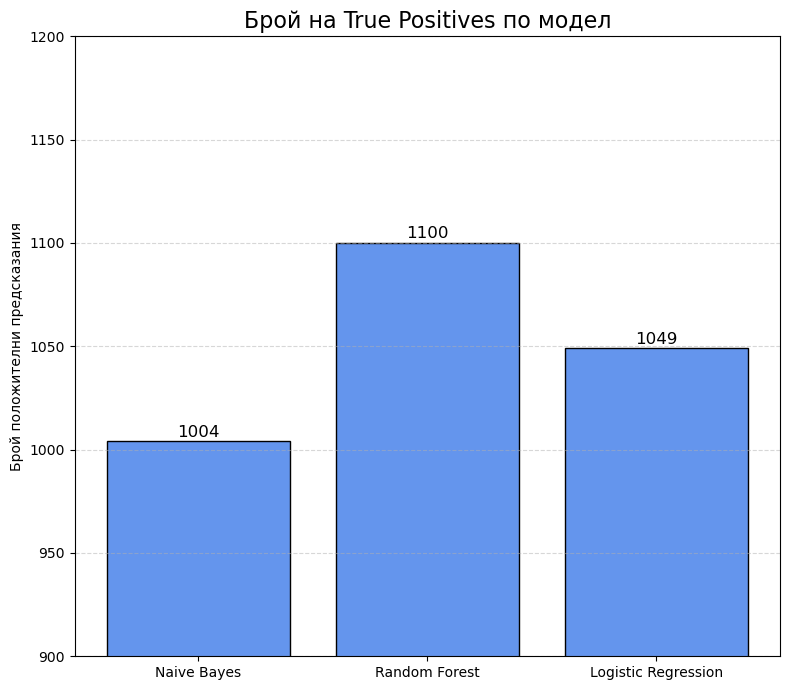

In [80]:
# Абсолютен брой True Positives за всеки модел
tp_counts = [tp_nb, tp_rf, tp_lr]

plt.figure(figsize=(8, 7))
bars = plt.bar(models, tp_counts, color='cornflowerblue', edgecolor='black')
plt.title('Брой на True Positives по модел', fontsize=16)
plt.ylabel('Брой положителни предсказания')
plt.ylim(900, max(tp_counts) + 100)

for bar, tp in zip(bars, tp_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.8, f'{tp}', 
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

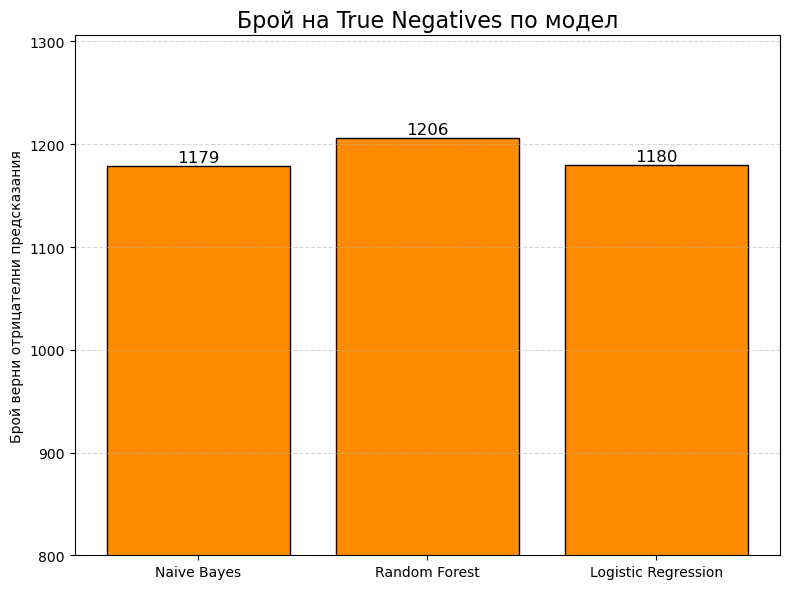

In [82]:
tn_counts = [tn_nb, tn_rf, tn_lr] 

plt.figure(figsize=(8, 6))
bars = plt.bar(models, tn_counts, color='darkorange', edgecolor='black')
plt.title('Брой на True Negatives по модел', fontsize=16)
plt.ylabel('Брой верни отрицателни предсказания')
plt.ylim(800, max(tn_counts) + 100)

for bar, tn in zip(bars, tn_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{tn}', 
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

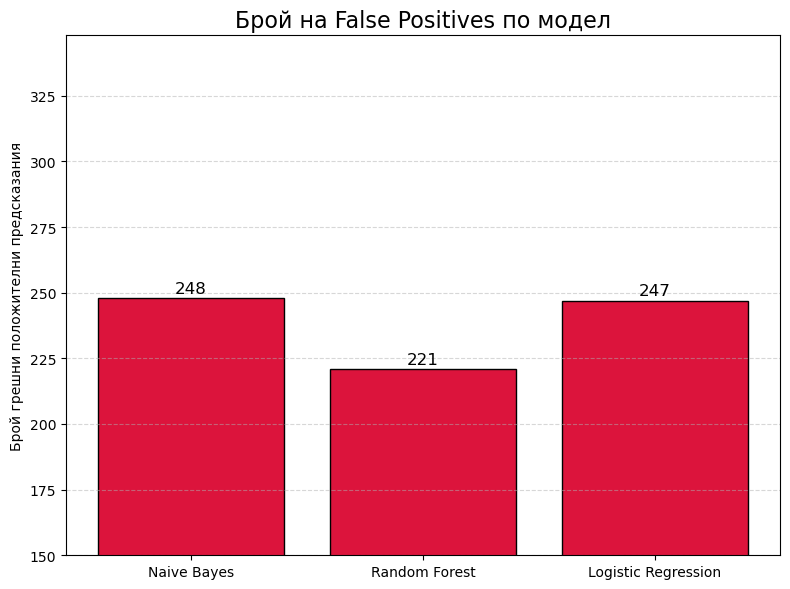

In [84]:
fp_counts = [fp_nb, fp_rf, fp_lr] 

plt.figure(figsize=(8, 6))
bars = plt.bar(models, fp_counts, color='crimson', edgecolor='black')
plt.title('Брой на False Positives по модел', fontsize=16)
plt.ylabel('Брой грешни положителни предсказания')
plt.ylim(150, max(fp_counts) + 100)

for bar, fp in zip(bars, fp_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.8, f'{fp}', 
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

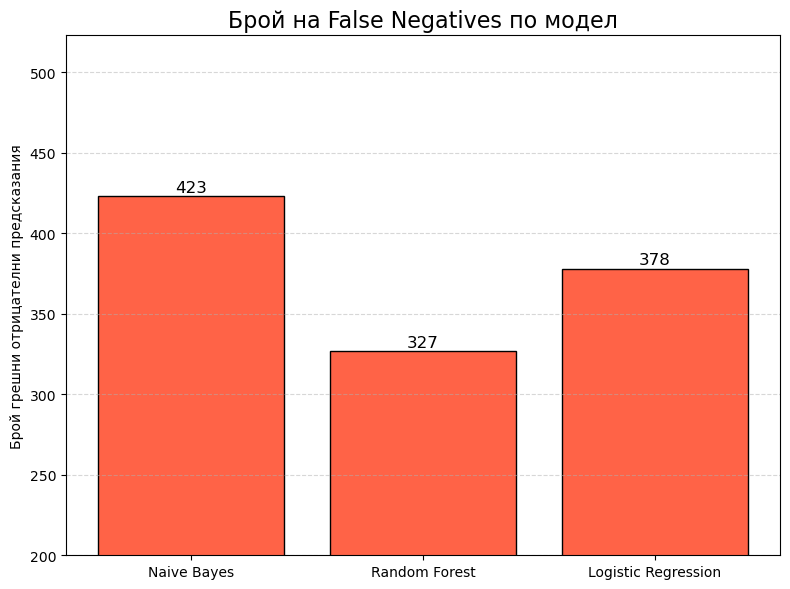

In [86]:
fn_counts = [fn_nb, fn_rf, fn_lr] 

plt.figure(figsize=(8, 6))
bars = plt.bar(models, fn_counts, color='tomato', edgecolor='black')
plt.title('Брой на False Negatives по модел', fontsize=16)
plt.ylabel('Брой грешни отрицателни предсказания')
plt.ylim(200, max(fn_counts) + 100)

for bar, fn in zip(bars, fn_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.8, f'{fn}', 
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()